<a href="https://colab.research.google.com/github/youssefbourais0310/Neural_Networks/blob/main/dog_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# End to end multi class breed classification 

this notebook builds an end to end multi class image classifier using tensorflow 2.0 and tensorflow hub .

## 1.problem

identifying the breed of a dog given an image of a dog

## 2.data

the data we are using from kaggle https://www.kaggle.com/c/dog-breed-identification/data?select=test

## 3.evaluation

the evaluation is a file with prediction probabillity for each dog breed of each test image .
https://www.kaggle.com/c/dog-breed-identification/overview

## 4.features

* we have unstructed data 
* there are 120 breed of dogs (120 diffrent classes 
* 10,000 + image in the traning set (the images have labels)
* 10,000 + images in the test set (the images have no labels)

In [1]:
# Unzip the uploaded data into google drive 
#!unzip "drive/MyDrive/dog_vision/dog-breed-identification(1).zip" -d "drive/MyDrive/dog_vision/"

### get our worspace ready 
* import tensorflow 2.x 
* import tensorflow hub
* make sure we are using GPU

In [2]:
#import tensorflow into colab
import tensorflow as tf
import tensorflow_hub as hub 
print("TF version:", tf.__version__)
print("TF hub version :", hub.__version__)

#check for GPU avaibility
print("GPU", "avaibility : (YES )" if tf.config.list_physical_devices("GPU") else "not available ")

TF version: 2.7.0
TF hub version : 0.12.0
GPU avaibility : (YES )


## getting our data ready (turning into tensors)
 with all machine learning model our data has to be in numerical format ,so thats what we will be doing 
turning our images into tensors(numerical representation).

* start by accessing our data and cheacking out the labels.

In [3]:
# checkout the lables of our data
import pandas as pd
labels_csv = pd.read_csv("drive/MyDrive/dog_vision/labels.csv")
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     7804443416f4fb5ac314f0df5301a115  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [4]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


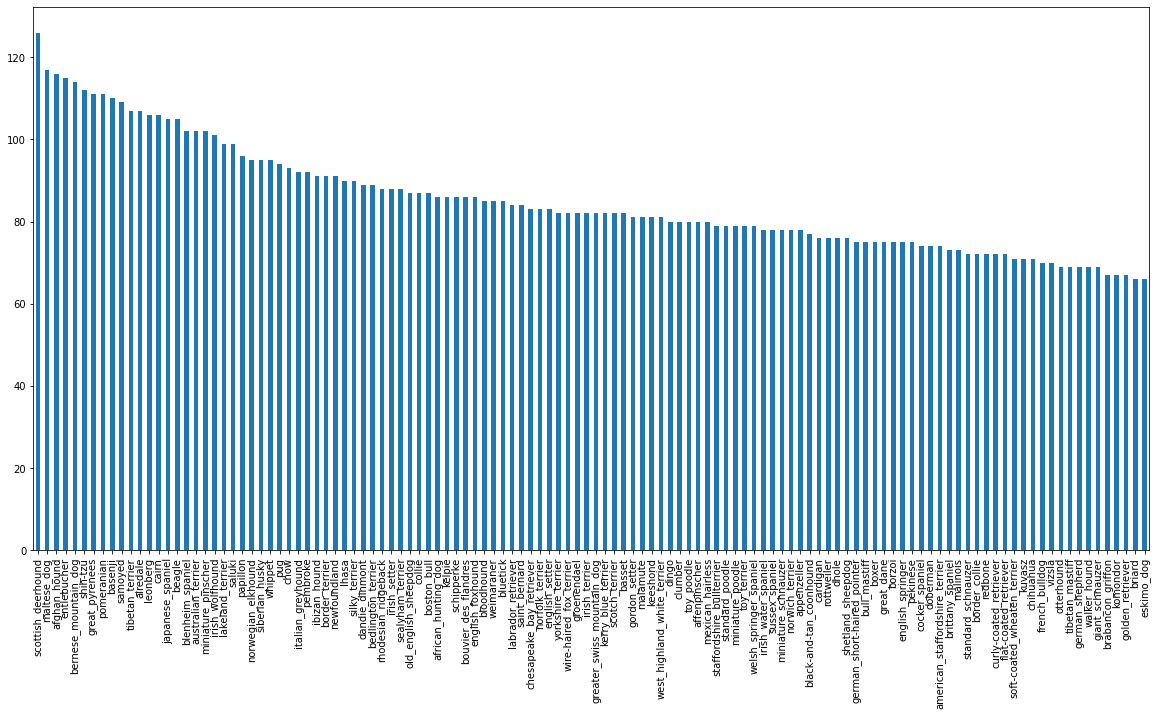

In [5]:
#how many images are there of each breed ?
labels_csv["breed"].value_counts().plot.bar(figsize=(20,10))

In [6]:
labels_csv["breed"].value_counts().median()

82.0

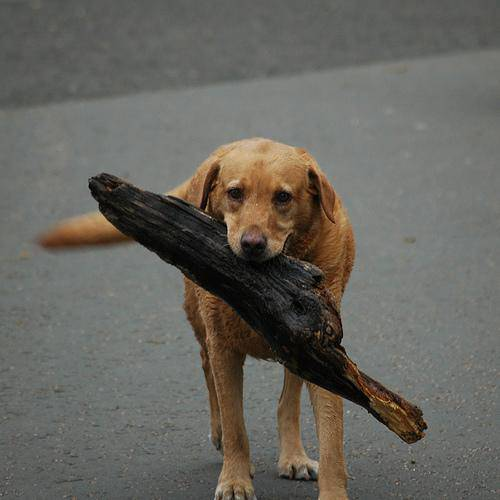

In [7]:
#lets view an image 
from IPython.display import Image 
Image("drive/MyDrive/dog_vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg")

### getting images and their labels
lets get a list of all of our image file pathnames

In [8]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [9]:
#create pathnames from images ID 
filepaths = ["drive/MyDrive/dog_vision/train/" + fpath + ".jpg" for fpath in labels_csv["id"]]

# check the first 10
filepaths[:10]

['drive/MyDrive/dog_vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/dog_vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/MyDrive/dog_vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/MyDrive/dog_vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/MyDrive/dog_vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/MyDrive/dog_vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/MyDrive/dog_vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/MyDrive/dog_vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/MyDrive/dog_vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/MyDrive/dog_vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [10]:
# check whether of filenames matches number of actual image files 
import os 
if len(os.listdir("drive/MyDrive/dog_vision/train/")) == len(filepaths):
  print("filepaths match actual amount of files ! proceed.")
else :
  print ("filepaths do not match actual amount of files , check the target directory.")

filepaths match actual amount of files ! proceed.


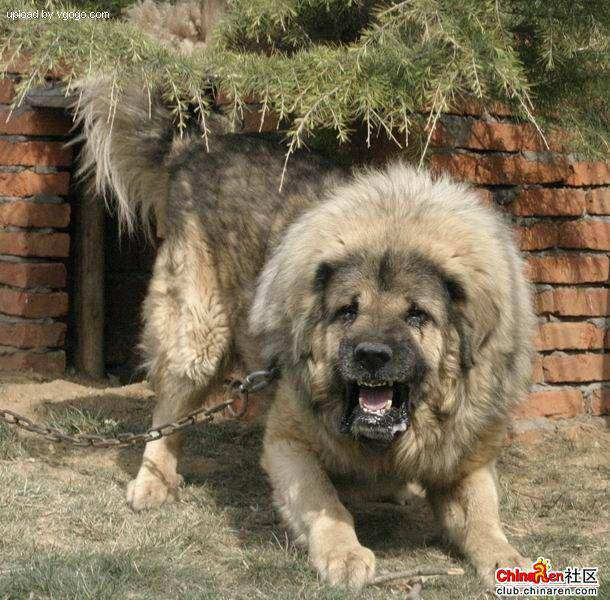

In [11]:
# one more check
Image(filepaths[9000])

In [12]:
labels_csv["breed"][9000]


'tibetan_mastiff'

# lets prepare our labels

In [13]:
import numpy as np
labels = labels_csv["breed"].to_numpy()
#labels = np.array(labels) #does same thing as above
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [14]:
len(labels)

10222

In [15]:
#see if numbers of labels of number of filenames 
if len(labels) == len(filepaths):
  print("number of labels matches number of filenames")
else : 
  print("number of labels does not match of file names , check data directories!")


number of labels matches number of filenames


In [16]:
# find the unique label values
unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [17]:
unique_breeds

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

In [18]:
# Turn a single label into a booleans
print(labels[0])
labels[0] == unique_breeds 

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [19]:
# Turn every label into a boolean array
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [20]:
len(boolean_labels)

10222

In [21]:
boolean_labels

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [22]:
from numpy.ma.extras import unique
#exemple : turning boolean array into integers 
print(labels[0]) #original label
print(np.where(unique_breeds == labels[0])) #index where label occurs
print(boolean_labels[0].argmax()) #index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # there will be a 1 where the sample occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [23]:
print(labels[2])
print(boolean_labels[2].astype(int))

pekinese
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [24]:
filepaths[:2]

['drive/MyDrive/dog_vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/dog_vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg']

### craeting our own validation set
since the dataset from kaggal doesnt come with a validation set we are going to creat our own

In [25]:
#setup x & y variable 
X = filepaths
y = boolean_labels

In [26]:
len(filepaths)

10222

we wre going to start experimenting with 1000 images and increase as needed

In [27]:
# set number of images to use for experementing 
NUM_IMAGES = 1000 #@param {type :"slider" , min : 1000, max : 10000 , step : 1000}

In [28]:
# lets split our data into train and validation sets
from sklearn.model_selection import train_test_split

#split them into ytaining and validation of total size NUM_IMAGES
X_train,X_val,y_train,y_val = train_test_split(X[:NUM_IMAGES],
                                               y[:NUM_IMAGES],
                                               test_size=0.2,
                                               random_state=42)

len(X_train), len(y_train), len(X_val), len(y_val)


(800, 800, 200, 200)

In [29]:
#lets have a geez at the training data
X_train[:2], y_train[:2]

(['drive/MyDrive/dog_vision/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'drive/MyDrive/dog_vision/train/0d2f9e12a2611d911d91a339074c8154.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, Fal

## preproccessing images (turning images into tensors)

to preproccess our images into tensors we are goin to write a function which does a few things :

1. take an image filepath as input
2. use tensorflow to read the file and save it to a variable , "image"
3. turn our "image" (a jpg) into tensors 
4. normalize our image (convert colour channel values from 0-255 to 0-1)
5. resize the "images" to be a shape of (224, 224)
6. return the modified "image"

In [30]:
# convert an image to numpy array
from matplotlib.pyplot import imread
image = imread(filepaths[42])
image.shape 

(257, 350, 3)

In [31]:
image.max(), image.min()

(255, 0)

In [32]:
image[:2]

array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]]], dtype=uint8)

In [33]:
# turn image into tensors
tf.constant(image[:2])

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]]], dtype=uint8)>

now we have seen what an image looks like as a tensor , let s make a function to preprocess them .

1. take an image filepath as input
2. use tensorflow to read the file and save it to a variable , "image"
3. turn our "image" (a jpg) into tensors 
4. normalize our image (convert colour channel values from 0-255 to 0-1)
5. resize the "images" to be a shape of (224, 224)
6. return the modified "image"

In [34]:
# Define image size
IMG_SIZE = 224

#creat a funtion for preprocessing images

def process_image(image_path,img_size=IMG_SIZE) :
  """ 
  takes an image file path and turns the image into tensors.
  """
  # read in an image file 
  image = tf.io.read_file(image_path)
  # turn the jpeg image into numerical tensors with 3 colour channels (red, green, blue)
  image = tf.image.decode_jpeg(image, channels=3)
  # convert the colour channel values from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # resize the image to our desired value (224, 224)
  image = tf.image.resize(image, size =[IMG_SIZE,IMG_SIZE])

  return image


## turning our data into batches

why turn data into batches ?

if we trying to process 10,000+ images in one go... they all mighte not fit into memory

so thats why we do about 32 (batch size ) images at a time (you can manually adjust the batch size if need be)

in order to use tensorflow effectively , we need our data in the form of tensor tuples which look like this :    
"(image, label)" .

In [35]:
# creat a simple function to return a tuple (image , label)
def get_image_label(image_path,label) : 

   """
   take an image file path name and assosciatd label,
   processes the image and return a typle of (image, label).
   """
   image = process_image(image_path)
   return image, label 

In [36]:
# Demo of the above
(process_image(X[42]), tf.constant(y[42]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

###now we"ve got a way to turn our data into tuples of tensors in the form : "(image, label), let"s make a function  to turn all of our data (X ,y) into batches

In [46]:
# define the batche size , 32 is a good start
BATCH_SIZE = 32

#creat a function to turn data into batches
def create_data_batches(X, y = None, batch_size = BATCH_SIZE, valid_data = False, test_data = False) :
  """
  create batches of data out of image (X) and label (y) pairs .
  shuffles the data if its training data but doesnt shuffle if its validation data.
  also accepts test data as input (no labels).
  """

  # if the data is a dataset , we probably dont have labels
  if test_data :
    print("creating test data batches ...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # only filepaths (no labels)
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  # if the data is a valid dataset , we dont need to shuffle it 
  elif valid_data :
    print("creating validation data batches ...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # only filepaths (no labels)
                                               tf.constant(y)))# labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)   
    return data_batch   

  else :
    print("creating training data batches ....")
    # turn filepaths and labels into tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                              tf.constant(y)))    

    # shuffling pathnames and labels before mapping image processor function is faster than shuffling images                        
    data = data.shuffle(buffer_size=len(X))

    # creat (image, label) tuples (this also turns the image path into a preprocessed image)
    data = data.map(get_image_label)

    # turn the trining data into batches
    data_batch = data.batch(BATCH_SIZE)
  return data_batch

In [47]:
#creating training and validation data batches 
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data = True)

creating training data batches ....
creating validation data batches ...


In [48]:
# cheak out the different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))